# Structure Function Turbulent Data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback, ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm

# verify cuda
torch.cuda.is_available()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
# device = 'cpu'
print('Torch in running on', device)

Torch in running on cuda:0


In [3]:
from turboflow.utils import phy_utils as phy
from turboflow.utils import dsp_utils as dsp

from turboflow.callbacks import RefineSolution

## Input data

Original size 256
Y shape (256, 256, 2)
Y min, max: -2.316562 2.692522
after normalization, Y min, max: -0.8603688289269317 1.0
Warning *** CHECK THE GRADIENT DIRECTION
Warning *** CHECK THE GRADIENT DIRECTION


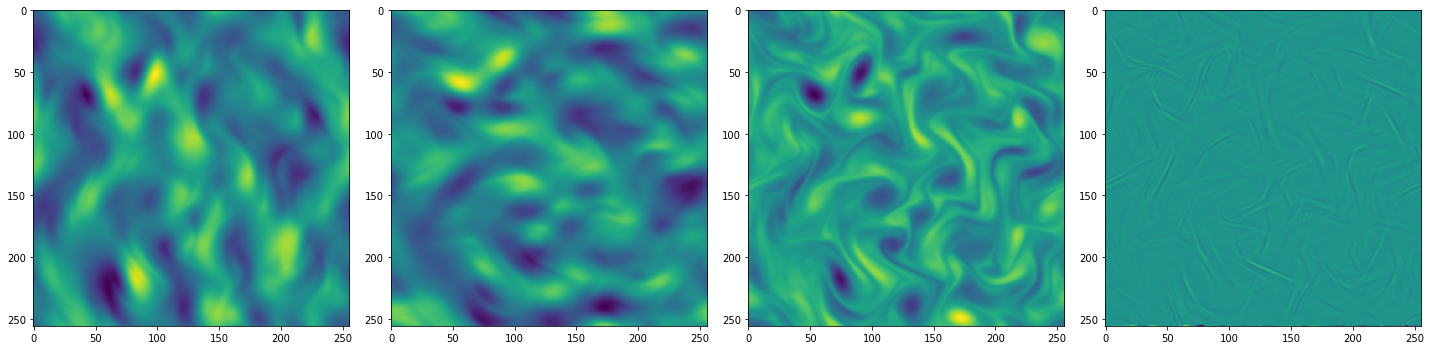

In [4]:
## SET UP DATA
path_to_data = '../data/2021-Turb2D_velocities.npy'
IMGs = np.load(path_to_data)
img_index = 55
X = IMGs[img_index,:,:,:2] / 255
U = IMGs[img_index,:,:,2:]
t = np.arange(0,IMGs.shape[0],step=0.01)
Re = 3900

original_size = X.shape[0]
print('Original size', original_size)

# normalize output
y = U.copy()
print('Y shape', y.shape)
print('Y min, max:', np.min(y), np.max(y))
y = y / np.max(np.abs(y))
print('after normalization, Y min, max:', np.min(y), np.max(y))

ytest = y.copy()
Xtest = X.copy()

W = phy.compute_vorticity(U[:,:,0],U[:,:,1])
D = phy.compute_divergence(U[:,:,0],U[:,:,1])

plt.figure(figsize=(20,20))
plt.subplot(141)
plt.imshow(U[:,:,0])
plt.subplot(142)
plt.imshow(U[:,:,1])
plt.subplot(143)
plt.imshow(W)
plt.subplot(144)
plt.imshow(D)
plt.tight_layout()
plt.show()

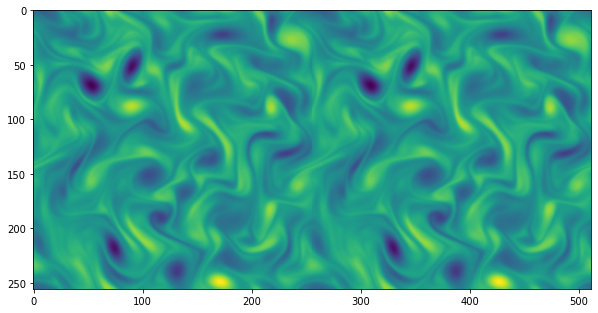

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(np.concatenate([W, W], axis=1))
plt.show()

Xtrain shape: (42, 42, 2)
ytrain shape: (42, 42, 2)


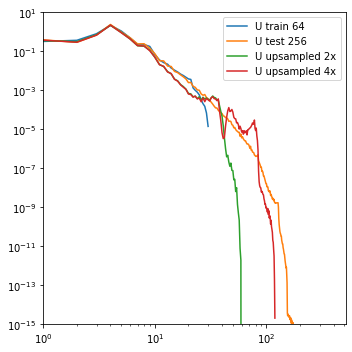

In [6]:
# downsampled resultion
scale = 1/6
coords = np.linspace(0, 1, int(original_size * scale), endpoint=False)
coords = np.stack(np.meshgrid(coords, coords), -1) # X x Y x 2
tmp = coords[:,:,0].copy()
coords[:,:,0] = coords[:,:,1]
coords[:,:,1] = tmp
Xtrain = coords
print('Xtrain shape:', Xtrain.shape)

y1ds = dsp.interpolate2D(X, y[:,:,0], scale=scale)[:,:,None]
y2ds = dsp.interpolate2D(X, y[:,:,1], scale=scale)[:,:,None]
ytrain = np.concatenate([y1ds, y2ds], axis=-1)
print('ytrain shape:', ytrain.shape)

# upsampled resolution
yup2 = dsp.interpolate2D(Xtrain, ytrain[:,:,0], scale=2)[:,:,None]
yup4 = dsp.interpolate2D(Xtrain, ytrain[:,:,0], scale=4)[:,:,None]


fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.loglog(np.arange(len(phy.powerspec(ytrain[:,:,0]))), phy.powerspec(ytrain[:,:,0]), label='U train 64')
axs.loglog(np.arange(len(phy.powerspec(ytest[:,:,0]))), phy.powerspec(ytest[:,:,0]), label='U test 256')
axs.loglog(np.arange(len(phy.powerspec(yup2[:,:,0]))), phy.powerspec(yup2[:,:,0]), label='U upsampled 2x')
axs.loglog(np.arange(len(phy.powerspec(yup4[:,:,0]))), phy.powerspec(yup4[:,:,0]), label='U upsampled 4x')
axs.set_ylim(10**(-15), 10)
axs.set_xlim(1, 512)
axs.legend()
plt.tight_layout()
plt.show()

# Dataset

In [7]:
class MyDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, X, y):

        assert np.max(np.abs(y)) <= 1
        assert np.max(np.abs(X)) <= 1

        'Initialization'
        print('X shape', X.shape)
        print('y shape', y.shape)
        try:
            assert X.shape[0] == y.shape[0]
            assert X.shape[1] == y.shape[1]
        except:
            print('*** Dimension error ***')
            print('X', X.shape)
            print('y', y.shape)
            
        H, W, Cin = X.shape
        H, W, Cout = y.shape
        
        # reshape s.t. B = H*W of query points
        X = X.reshape(H*W, Cin)
        y = y.reshape(H*W, Cout)
        
        self.size = H*W
        # convert to torch and add an empty dimension for the batch
        self.inputs = torch.from_numpy(X).float() #XY x 2 (x,y)
        self.target = torch.from_numpy(y).float()  #XxYx3 (RGB)
        
        assert self.inputs.shape[0] == self.target.shape[0]
        assert self.inputs.shape[1] == self.target.shape[1]
        
        print(self.inputs.shape)
        print(self.inputs.shape)

    def __len__(self):
        'Denotes the total number of samples'
        return self.size

    def __getitem__(self, idx):
        'Generates one sample of data'
        # Load data and get label
        X = self.inputs[idx,...]
        y = self.target[idx,...]

        return X, y


class DataModule(pl.LightningDataModule):
    def __init__(self, name, train_data, val_data, test_data, 
                 batch_size=2000, num_workers=8, shuffle=False):
        
        super().__init__()
        self.name = name
        self.num_workers = num_workers
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.train_data = train_data
        self.test_data = test_data
        self.val_data = val_data
        
    def prepare_data(self):
        self.train_dataset = MyDataset(self.train_data[0], self.train_data[1])
        self.val_dataset = MyDataset(self.val_data[0], self.val_data[1])
        self.test_dataset = MyDataset(self.test_data[0], self.test_data[1])
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, self.batch_size, num_workers = self.num_workers, shuffle=self.shuffle)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, self.batch_size, num_workers = self.num_workers, shuffle=self.shuffle)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, self.batch_size, num_workers = self.num_workers, shuffle=self.shuffle)

X shape (64, 64, 2)
y shape (64, 64, 2)
torch.Size([4096, 2])
torch.Size([4096, 2])
X shape (64, 64, 2)
y shape (64, 64, 2)
torch.Size([4096, 2])
torch.Size([4096, 2])
X shape (64, 64, 2)
y shape (64, 64, 2)
torch.Size([4096, 2])
torch.Size([4096, 2])
Train
torch.Size([4096, 2]) torch.Size([4096, 2])


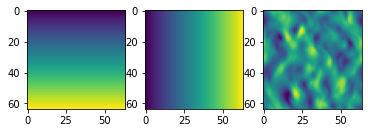

Validation
torch.Size([4096, 2]) torch.Size([4096, 2])


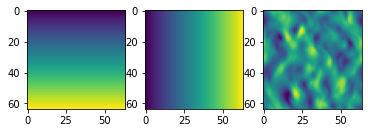

In [8]:
low_scale = 1/4
curr_res = int(original_size * low_scale)

Xlow = np.concatenate([
            dsp.interpolate2D(X, Xtest[:,:,0], scale=low_scale)[:,:,None],
            dsp.interpolate2D(X, Xtest[:,:,1], scale=low_scale)[:,:,None]], 
       axis=-1)
ylow = np.concatenate([
            dsp.interpolate2D(X, ytest[:,:,0], scale=low_scale)[:,:,None],
            dsp.interpolate2D(X, ytest[:,:,1], scale=low_scale)[:,:,None]],
        axis=-1)

dm = DataModule(
    name = 'Turbo2D-%d' % img_index,
    train_data=[Xlow, ylow],
    val_data=[Xlow, ylow],
    test_data=[Xlow, ylow],
    batch_size = 128**2,
    shuffle=False,
)

## test
dm.prepare_data()
print('Train')
for batch in dm.train_dataloader():
    x, y = batch
    print(x.shape, y.shape)
    
    plt.subplot(131)
    xshow = x.cpu().detach().numpy().squeeze()
    plt.imshow(xshow.reshape(curr_res,curr_res,2)[:,:,0])
    plt.subplot(132)
    xshow = x.cpu().detach().numpy().squeeze()
    plt.imshow(xshow.reshape(curr_res,curr_res,2)[:,:,1])
    plt.subplot(133)
    yshow = y.cpu().detach().numpy().squeeze()
    plt.imshow(yshow.reshape(curr_res,curr_res,2)[:,:,0])
    plt.show()

print('Validation')
for batch in dm.val_dataloader():
    x, y = batch
    print(x.shape, y.shape)
    plt.subplot(131)
    xshow = x.cpu().detach().numpy().squeeze()
    plt.imshow(xshow.reshape(curr_res,curr_res,2)[:,:,0])
    plt.subplot(132)
    xshow = x.cpu().detach().numpy().squeeze()
    plt.imshow(xshow.reshape(curr_res,curr_res,2)[:,:,1])
    plt.subplot(133)
    yshow = y.cpu().detach().numpy().squeeze()
    plt.imshow(yshow.reshape(curr_res,curr_res,2)[:,:,0])
    plt.show()

# Model

## RFF on batch

In [9]:
class Fourier(nn.Module):
    
    def __init__(self, nfeat, scale):
        super(Fourier, self).__init__()
        self.b = nn.Parameter(torch.randn(2, nfeat)*scale, requires_grad=False)
        self.pi = 3.14159265359

    def forward(self, x):
        x = torch.einsum('bc,cf->bf', 2*self.pi*x, self.b.to(x.device))
        return torch.cat([torch.sin(x), torch.cos(x)], -1)

    
def LinearReLU(n_in, n_out):
    # do not work with ModuleList here either.
    block = nn.Sequential(
      nn.Linear(n_in, n_out),
      nn.ReLU()
    )
    return block

    
class MLP(nn.Module):
    
    def __init__(self, dim_layers):
        super(MLP, self).__init__()
        layers = []
        num_layers = len(dim_layers)
        
        blocks = []
        for l in range(num_layers-2):
            blocks.append(LinearReLU(dim_layers[l], dim_layers[l+1]))
            
        blocks.append(nn.Linear(dim_layers[-2], dim_layers[-1]))
        blocks.append(nn.Tanh())
        self.network = nn.Sequential(*blocks)
    
    def forward(self, x):
        return self.network(x)

    
class RFFNet_pl(pl.LightningModule):
    
    def __init__(self, name, dim_mpl_layers, f_nfeatures, f_scale, random_matrix=None, lam_pde=1e-4):
        super(RFFNet_pl, self).__init__()
        self.name = name
        self.automatic_optimization = True
        
        # regression/pinn network       
        self.rff = Fourier(f_nfeatures, f_scale) # directly the random matrix 'cause of checkpoint and load
        self.mlp = MLP(dim_mpl_layers)
        
        # PINN losses
        self.lam_pde = lam_pde
        
        # other params
        # self.mode = mode # pre_train with adam, fine_tune with bsgf
        
        # for loading from checkpoints
        self.save_hyperparameters('name', 'dim_mpl_layers', 'f_nfeatures', 'f_scale', 'lam_pde')
    
    def forward(self, x): # x := BxC(Batch, InputChannels)
        ## implement periodicity
        x = torch.remainder(x,1)
        ## Fourier features
        x = self.rff(x) # Batch x Fourier Features
        ## MLP
        x = self.mlp(x)
        return x

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, x_true = batch
        x.requires_grad_(True) # for computing the grad in the loss_pde
        x_pred = self.forward(x)
        # reconstruction loss
        loss_rec = F.mse_loss(x_pred, x_true)
        # pde loss: div(u) = 0
        if self.lam_pde > 0:
            u, v = torch.split(x_pred,1,-1)
            du_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]       
            dv_y = torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True)[0]
            div_u = du_x[...,0] + dv_y[...,1]
            loss_pde = torch.norm(div_u)
            loss = loss_rec + self.lam_pde*loss_pde
        else:
            loss = loss_rec
        # Logging to TensorBoard by default
        self.log('train_loss', loss)
        self.log('train_loss_data', loss_rec)
        return loss

    
    def validation_step(self, batch, batch_idx):
        # enable gradient
        torch.set_grad_enabled(True)
        x, x_true = batch
        x.requires_grad_(True) # for computing the grad in the loss_pde
        x_pred = self.forward(x)
        # reconstruction loss
        loss_rec = F.mse_loss(x_pred, x_true)
        # pde loss: div(u) = 0
        if self.lam_pde > 0:
            u, v = torch.split(x_pred,1,-1)
            du_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]       
            dv_y = torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True)[0]
            div_u = du_x[...,0] + dv_y[...,1]
            loss_pde = torch.norm(div_u)
            loss = loss_rec + self.lam_pde*loss_pde
        else:
            loss = loss_rec
        self.log('valid_loss', loss, on_step=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
#         scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
        return {"optimizer": optimizer}
#                 "lr_scheduler": scheduler, 
#                 "monitor": "valid_loss"}

In [10]:
# LIST OF MODELS
n_features = 256
dim_mlp_layers = [2*n_features] + 3*[256] + [2]
scale = 10

models_hparams = {
    'RFFNet' : {
        'name' : 'RFFNet',
        'lam_pde' : 0,
    },
    'PhyRFFNet' : {
        'name' : 'PhyRFFNet',
        'lam_pde' : 1e-4,
    }
}

In [11]:
curr_model_name = 'RFFNet'
model = RFFNet_pl(curr_model_name, 
                  dim_mlp_layers, 
                  n_features, 
                  scale, 
                  lam_pde=models_hparams[curr_model_name]['lam_pde'])
print(model)

RFFNet_pl(
  (rff): Fourier()
  (mlp): MLP(
    (network): Sequential(
      (0): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
      (2): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
      (3): Linear(in_features=256, out_features=2, bias=True)
      (4): Tanh()
    )
  )
)


In [12]:
checkpoint_dir = '../torch_checkpoints/'

In [13]:
# early_stop_callback = EarlyStopping(monitor='valid_loss')
# refine_sol_callback = RefineSolution(thr=1e-7)
# checkpoint_callback = ModelCheckpoint(
#     monitor="valid_loss",
#     dirpath=checkpoint_dir,
#     filename="%s-%s-{epoch:02d}-{valid_loss:.5f}" % (dm.name, model.name),
#     save_top_k=3,
#     mode="min",
# )

# trainer = pl.Trainer(gpus=1, 
#                      check_val_every_n_epoch=10, 
#                      max_epochs=int(10e3), 
#                      callbacks=[early_stop_callback, checkpoint_callback])
# trainer.fit(model, dm)

# # save models
# best_model_path = checkpoint_callback.best_model_path
# print(checkpoint_callback.best_model_path)
# torch.save(model.state_dict(), best_model_path.replace('ckpt','torch'))

In [14]:
fname_phy = 'Turbo2D-55-PhyRFFNet-epoch=619-valid_loss=0.00560.ckpt'
fname_rff = 'Turbo2D-55-RFFNet-epoch=549-valid_loss=0.00000.ckpt'

best_model_rff = RFFNet_pl.load_from_checkpoint(checkpoint_dir + fname_rff)
best_model_phy = RFFNet_pl.load_from_checkpoint(checkpoint_dir + fname_phy)

In [15]:
print(best_model_phy.device)
print(best_model_rff.device)

cpu
cpu


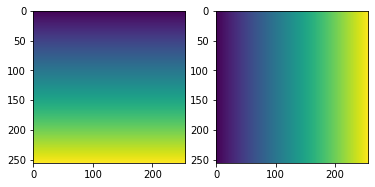

(65536, 2)


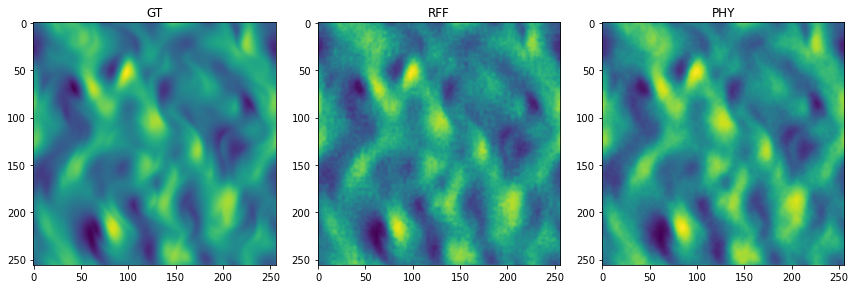

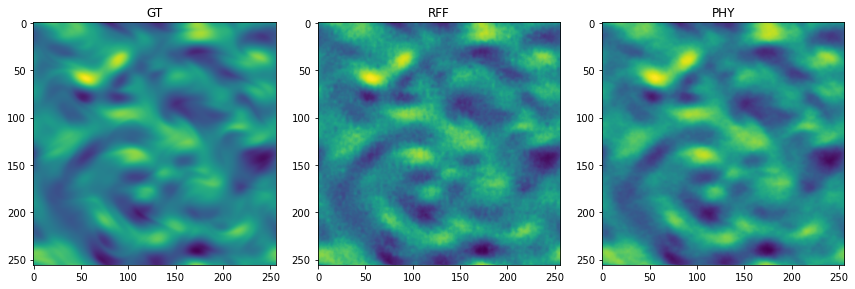

In [16]:
# TEST
ngrid = 256
coords = np.linspace(0, 1, ngrid)
coords = np.stack(np.meshgrid(coords, coords), -1) # X x Y x 2
tmp = coords[:,:,0].copy()
coords[:,:,0] = coords[:,:,1]
coords[:,:,1] = tmp

plt.subplot(121)
plt.imshow(coords[:,:,0])
plt.subplot(122)
plt.imshow(coords[:,:,1])
plt.show()

coords = coords.reshape(ngrid*ngrid,2)
print(coords.shape)

x = torch.from_numpy(coords).float().to(device)

best_model_phy.to(device)
best_model_phy.eval()

best_model_rff.to(device)
best_model_rff.eval()

ypred_rff = best_model_rff(x).cpu().detach().numpy().squeeze()
ypred_phy = best_model_phy(x).cpu().detach().numpy().squeeze()
# ypred = model(x).cpu().detach().numpy().squeeze()


plt.figure(figsize=(12,6))
plt.subplot(131)
plt.imshow(ytest[:,:,0])
plt.title('GT')
plt.subplot(132)
plt.imshow(ypred_rff.reshape(ngrid,ngrid,2)[:,:,0])
plt.title('RFF')
plt.subplot(133)
plt.imshow(ypred_phy.reshape(ngrid,ngrid,2)[:,:,0])
plt.title('PHY')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
plt.subplot(131)
plt.title('GT')
plt.imshow(ytest[:,:,1])
plt.subplot(132)
plt.title('RFF')
plt.imshow(ypred_rff.reshape(ngrid,ngrid,2)[:,:,1])
plt.subplot(133)
plt.title('PHY')
plt.imshow(ypred_phy.reshape(ngrid,ngrid,2)[:,:,1])
plt.tight_layout()
plt.show()

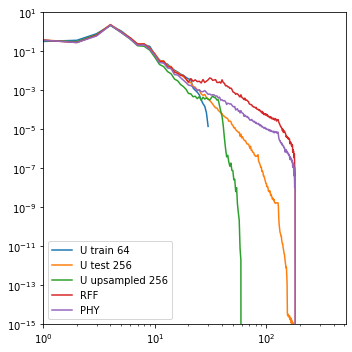

In [17]:
fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.loglog(np.arange(len(phy.powerspec(ytrain[:,:,0]))), phy.powerspec(ytrain[:,:,0]), label='U train 64')
axs.loglog(np.arange(len(phy.powerspec(ytest[:,:,0]))), phy.powerspec(ytest[:,:,0]), label='U test 256')
axs.loglog(np.arange(len(phy.powerspec(yup2[:,:,0]))), phy.powerspec(yup2[:,:,0]), label='U upsampled 256')
axs.loglog(np.arange(len(phy.powerspec(ypred_rff.reshape(ngrid,ngrid,2)[:,:,0]))), 
                         phy.powerspec(ypred_rff.reshape(ngrid,ngrid,2)[:,:,0]), label='RFF')
axs.loglog(np.arange(len(phy.powerspec(ypred_phy.reshape(ngrid,ngrid,2)[:,:,0]))), 
                         phy.powerspec(ypred_phy.reshape(ngrid,ngrid,2)[:,:,0]), label='PHY')
axs.set_ylim(10**(-15), 10)
axs.set_xlim(1, 512)
axs.legend()
plt.tight_layout()
plt.show()

In [18]:
num_centers = 10
num_scales = 5

zoom_factors = [2, 3, 4, 5, 6] # 1/4 of the subsampled original scale

print('Curr size:', curr_res)
print('Highest res:', original_size)
print('Best zoom:', original_size // curr_res)
print('Zoom factors:', zoom_factors)
print('Image dimensions:', [int(64 * z) for z in zoom_factors])
num_resolutions = len(zoom_factors)

Curr size: 64
Highest res: 256
Best zoom: 4
Zoom factors: [2, 3, 4, 5, 6]
Image dimensions: [128, 192, 256, 320, 384]


In [19]:
patch_dim = 32 # make everything at 32x32
num_centers = 5

print('Patch dimensions:', patch_dim)
print('Number of centers:', num_centers)

Patch dimensions: 32
Number of centers: 5


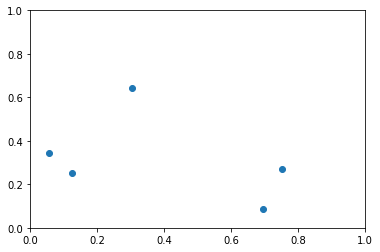

In [20]:
distribution = torch.distributions.Uniform(torch.Tensor([0]),torch.Tensor([1]))
centres = distribution.sample(torch.Size([num_centers,2])).to(device)

plt.scatter(centres.cpu().numpy()[:,0],
            centres.cpu().numpy()[:,1])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

In [22]:
model = best_model_phy
model.to(device)

RFFNet_pl(
  (rff): Fourier()
  (mlp): MLP(
    (network): Sequential(
      (0): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
      (2): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
      (3): Linear(in_features=256, out_features=2, bias=True)
      (4): Tanh()
    )
  )
)

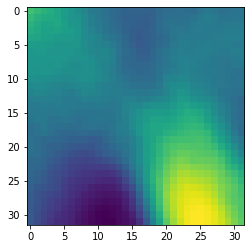

IndexError: index 2 is out of bounds for dimension 3 with size 2

In [23]:
L = 100 # num of increments
C = 5   # num of centers
D = 1   # num of directions

min_scale = 1/original_size # step size between each increments

S2 = torch.zeros(C, D, L, 2)

directions = [[1,0],[1,1],[0,1]]

for d, D in enumerate(directions): # for each direction
    for c, C in enumerate(centres): # for each random point
        # patch around the center
        patch_ln = torch.linspace(-0.1, 0.1, patch_dim, device=device)
        patch_sq = torch.stack(torch.meshgrid(patch_ln+C[0], patch_ln+C[1]), dim=-1)
        
        # predict the patch
        v = best_model_phy(patch_sq.view(-1,2))
        
        for l in range(L): # for each increments
            
            increments = torch.Tensor([min_scale*l*D[0],
                                       min_scale*l*D[1]]).to(device) # diagonal increment
            
            patch_sq_l = patch_sq.clone() + increments[None,None,:]
            vl = model(patch_sq_l.view(-1,2))
            
            plt.imshow(vl.reshape(patch_dim,patch_dim,2)[:,:,0].detach().cpu().numpy())
            plt.show()
            
            diff = (vl - v)**2
            S2[c,d,l, 2] =  torch.mean(diff)
    

-0.5 0.5


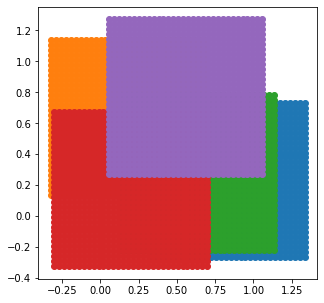

-0.3333333333333333 0.3333333333333333


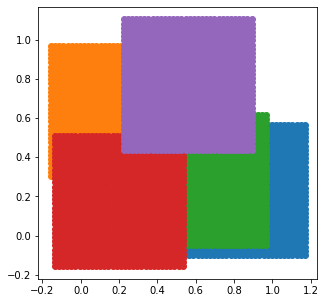

-0.25 0.25


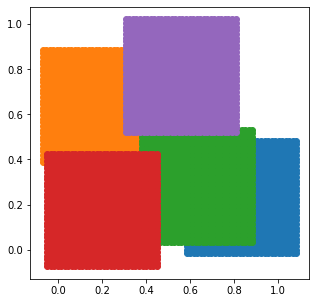

-0.2 0.2


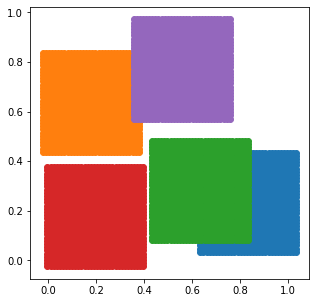

-0.16666666666666666 0.16666666666666666


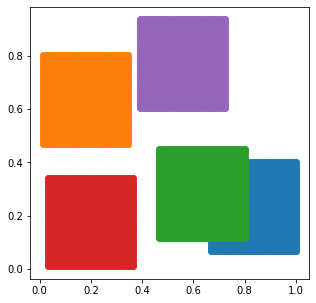

In [127]:
patches = torch.empty((num_centers,num_scales,patch_dim*patch_dim,2), dtype=torch.float, device=device)

for z, Z in enumerate(zoom_factors):
    patch_ln = torch.linspace(-1/Z, 1/Z, patch_dim, device=device)
    
    print(-1/Z, 1/Z)
    
    plt.figure(figsize=(5,5))
    
    for c, C in enumerate(centres):
        patch_sq = torch.stack(torch.meshgrid(patch_ln+C[0], patch_ln+C[1]), dim=-1)
        patches[c,s,:,:] = patch_sq.view(-1,2)
        
        
        plt.scatter(patches[c,s,:,0].cpu().numpy(),
                    patches[c,s,:,1].cpu().numpy())
    plt.show()

In [ ]:
import math

model = best_model_phy

L = 32 # num increments (=patch size)
D = 4 # num of diagonal directions

for z, Z in enumerate(zoom_factors):
    
    Sd = torch.zeros(L, num_centers,D).to(device)
    
    for c, C in enumerate(centres):
        
        # make a patch
        patch_ln = torch.linspace(-1/Z, 1/Z, patch_dim, device=device)
        # traslate it
        patch_sq = torch.stack(torch.meshgrid(patch_ln+C[0], patch_ln+C[1]), dim=-1)

        # predict the patch
        v = best_model_phy(patch_sq.view(-1,2))
        
#         plt.figure()
#         plt.subplot(121)
#         plt.scatter(patch_sq.view(-1,2)[:,0].cpu().numpy(),
#                     patch_sq.view(-1,2)[:,1].cpu().numpy())
#         plt.xlim([-2, 2])
#         plt.ylim([-2, 2])
#         plt.subplot(122)
#         plt.imshow(v.reshape(patch_dim,patch_dim,2)[:,:,0].cpu().detach().numpy())
#         plt.show()
#         1/0
        
        # for each increment for each direction
        increment = 1/(patch_dim*Z)
        directions = [[-1,-1],[1,-1],[-1,1],[1,1]]
        
        for l in range(L):
            for d in directions:
                increments = torch.Tensor([increment*l*d[0],
                                           increment*l*d[1]]).to(device) # diagonal increment
                print(patch_sq[:,:,0])
                print(increments)
                patch_sq_l = patch_sq.clone() + increments[None,None,:]
                vl = model(patch_sq_l.view(-1,2))
            
                plt.imshow(vl.reshape(patch_dim,patch_dim,2)[:,:,0].detach().cpu().numpy())
                plt.show()
                1/0
            
                diff = (vl - v)**2
                Sd[l,c,d] = torch.mean(diff)
    
    Sd = Sd.mean(axis=-1)
    
#     plt.figure()
#     coords = np.linspace(0,0.015625*32,32)
#     for c, C in enumerate(centres):
#         plt.loglog(Sd[:,c].detach().cpu().numpy(), label='emp %d' % c)
#     plt.loglog(coords,0.000275*coords**2, '--', label='model')
#     plt.legend()
#     plt.title('Structure function, zoom %f' % Z)
#     plt.show()

In [144]:
print([1/(patch_dim*Z) for Z in zoom_factors])

[0.015625, 0.010416666666666666, 0.0078125, 0.00625, 0.005208333333333333]


In [ ]:

L = 40

for l in range(L):
    v = x
    vl = x_padded[l:l+img_shape,l:l+img_shape,:]
    Sd[l] = np.mean((0.5*(vl[:,:,0]-v[:,:,0])+0.5*(vl[:,:,1]-v[:,:,1]))**2, axis=(0,1))

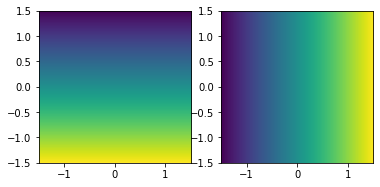

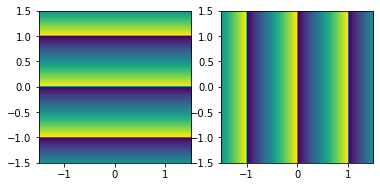

In [107]:
a = -1.5
b = 1.5

coords = np.linspace(a, b, ngrid)
coords = np.stack(np.meshgrid(coords, coords), -1) # X x Y x 2
tmp = coords[:,:,0].copy()
coords[:,:,0] = coords[:,:,1]
coords[:,:,1] = tmp

A = coords[:,:,0]
B = coords[:,:,1]

plt.subplot(121)
plt.imshow(A, extent=[a,b,a,b])
plt.subplot(122)
plt.imshow(B, extent=[a,b,a,b])
plt.show()

pcoords = coords % 1
Ap = pcoords[:,:,0]
Bp = pcoords[:,:,1]


plt.subplot(121)
plt.imshow(Ap,extent=[a,b,a,b])
plt.subplot(122)
plt.imshow(Bp,extent=[a,b,a,b])
plt.show()

In [27]:
nx, ny = U[:,:,0].shape

sfux = np.zeros((nx//2,2))
sfvx = np.zeros((nx//2,2))

sfux2 = 0.
sfvx2 = 0.
sfux3 = 0.
sfvx3 = 0.

u = U[:,:,0]
v = U[:,:,1]

for ii in range(nx//2):
    for j in range(ny):
        for i in range(nx-ii):
            sfux2 = (u[i+ii,j]-u[i,j])**2
            sfvx2 = (v[i+ii,j]-v[i,j])**2
            sfux3 = (u[i+ii,j]-u[i,j])**3
            sfvx3 = (v[i+ii,j]-v[i,j])**3
            sfux[ii,0] = sfux[ii,0]+sfux2
            sfvx[ii,0] = sfvx[ii,0]+sfvx2
            sfux[ii,1] = sfux[ii,1]+sfux3
            sfvx[ii,1] = sfvx[ii,1]+sfvx3
            
    sfux[ii,0]=sfux[ii,0]/((nx-ii)*ny)
    sfvx[ii,0]=sfvx[ii,0]/((nx-ii)*ny)
    sfux[ii,1]=sfux[ii,1]/((nx-ii)*ny)
    sfvx[ii,1]=sfvx[ii,1]/((nx-ii)*ny)

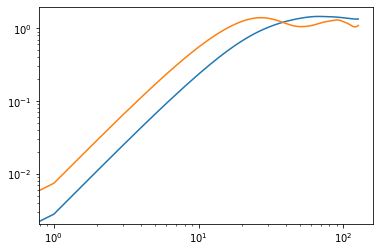

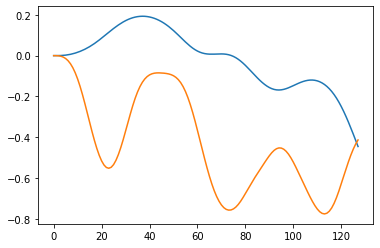

In [29]:
plt.loglog(sfux[:,0])
plt.loglog(sfvx[:,0])
plt.show()

plt.plot(sfux[:,1])
plt.plot(sfvx[:,1])
plt.show()

In [32]:
sfuy = np.zeros((ny//2,2))
sfvy = np.zeros((ny//2,2))

sfuy2 = 0.
sfvy2 = 0.
sfuy3 = 0.
sfvy3 = 0.

for jj in range(ny//2):
    for i in range(nx):
        for j in range(ny-jj):
            sfuy2 = (u[i,j+jj]-u[i,j])**2
            sfvy2 = (v[i,j+jj]-v[i,j])**2
            sfuy3 = (u[i,j+jj]-u[i,j])**3
            sfvy3 = (v[i,j+jj]-v[i,j])**3
            sfuy[jj,0] = sfuy[jj,0]+sfuy2
            sfvy[jj,0] = sfvy[jj,0]+sfvy2
            sfuy[jj,1] = sfuy[jj,1]+sfuy3
            sfvy[jj,1] = sfvy[jj,1]+sfvy3
            
    sfuy[jj,0]=sfuy[jj,0]/((ny-jj)*nx)
    sfvy[jj,0]=sfvy[jj,0]/((ny-jj)*nx)
    sfuy[jj,1]=sfuy[jj,1]/((ny-jj)*nx)
    sfvy[jj,1]=sfvy[jj,1]/((ny-jj)*nx)

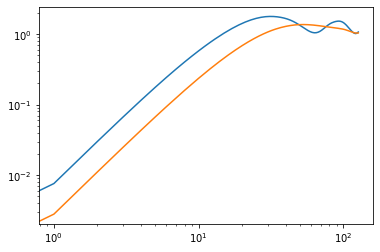

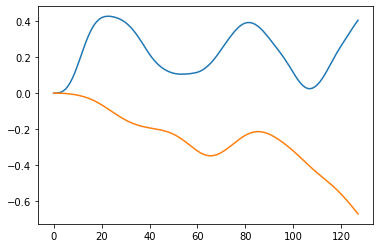

In [34]:
plt.loglog(sfuy[:,0])
plt.loglog(sfvy[:,0])
plt.show()

plt.plot(sfuy[:,1])
plt.plot(sfvy[:,1])
plt.show()

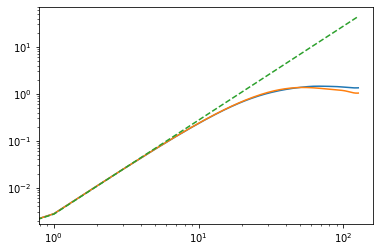

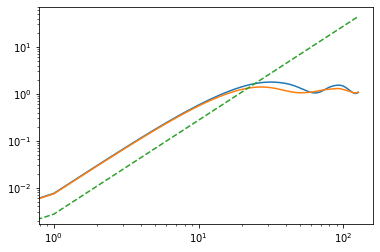

In [44]:
plt.loglog(sfux[:,0])
plt.loglog(sfvy[:,0])
plt.loglog(np.arange(nx//2), 0.00275*np.arange(nx//2)**2, '--', label='model')
plt.show()

plt.loglog(sfuy[:,0])
plt.loglog(sfvx[:,0])
plt.loglog(np.arange(nx//2), 0.00275*np.arange(nx//2)**2, '--', label='model')
plt.show()